# Face Mask Detection



Here I am going to detect whether a person is wearing mask or not. I am focussing on only two classes that are 'face_with_mask' and face_no_mask'.

### Source Page
+ [Kaggle Source](https://www.kaggle.com/ayushimishra2809/face-mask-detection)


### Setup

1. Create a new [Anaconda](https://www.anaconda.com/products/individual) environment with Python 3.6 (not 3.7 or 3.8), keras, and tensorflow:
``` sh
> conda create -n <your_env_name> python=3.6 anaconda tensorflow keras
```
2. Install other missing packages:
``` sh
> conda install -c anaconda xlrd xlwt scikit-learn seaborn
> conda install mtcnn ipyparallel
> pip install python-opencv
```
3. That's all for now!

## Importing Libraries

In [90]:
import numpy as np 
import pandas as pd 
import os
import urllib
import matplotlib.pyplot as plt
import cv2                                 # opencv-python installed with 'pip'
import matplotlib.patches as patches
import tensorflow as tf                    # TensorFlow installed with 'pip'
import keras
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential        # keras is only compatible with python 3.6 or lower
import sklearn
from sklearn.preprocessing import LabelEncoder
from mtcnn.mtcnn import MTCNN

In [91]:
# pip install mtcnn

In [92]:
# from mtcnn.mtcnn import MTCNN

# Loading datasets

+ [Correctly Masked Faces](https://esigelec-my.sharepoint.com/:f:/g/personal/cabani_esigelec_fr/Ev3GdnQSyzxPjyzU5ElHqagBlkRCaKnnCI85iX-d1L4OHA?e=G7uaYV)

+ [Incorrectly Masked Faces](https://esigelec-my.sharepoint.com/:f:/g/personal/cabani_esigelec_fr/EirjS8ew7-5LnO8I56Uk63wBKebwSlukFBFBaO8N25wn3g?e=Ho1jHG)

+ [Face Mask Detection Dataset (Kaggle)](https://www.kaggle.com/wobotintelligence/face-mask-detection-dataset)

In [93]:
# images=os.path.join("/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images")
# annotations=os.path.join("/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations")
# train=pd.read_csv(os.path.join("/kaggle/input/face-mask-detection-dataset/train.csv"))
# submission=pd.read_csv(os.path.join("/kaggle/input/face-mask-detection-dataset/submission.csv"))
notebook_dir = !pwd
root_dir = os.path.abspath(os.path.join(notebook_dir[0], os.pardir))
data_dir = os.path.join(root_dir, 'data')
images_dir = os.path.join(data_dir, 'images')
annotations_dir = os.path.join(data_dir, 'annotations')


# define directory paths for easier navigation
NOTEBOOK_DIR = !pwd
NOTEBOOK_DIR = NOTEBOOK_DIR[0]
ROOT_DIR = os.path.abspath(os.path.join(NOTEBOOK_DIR, os.pardir))
DATA_DIR = os.path.join(ROOT_DIR, 'data')

KAGGLE_IMAGES_DIR = "https://github.com/brtonnies/face-mask-detection/blob/data-branch/data/images"
CMFD_IMAGES_DIR = "https://github.com/brtonnies/face-mask-detection/blob/data-branch/data/images/CMFD/images"
IMFD_IMAGES_DIR = "https://github.com/brtonnies/face-mask-detection/blob/data-branch/data/images/IMFD/images"


train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
submission = pd.read_csv(os.path.join(data_dir, 'submission.csv'))

In [94]:
print(len(train))
train

15412


,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask
...,...,...,...,...,...,...
15407,1894.jpg,437,121,907,644,face_with_mask
15408,1894.jpg,557,363,876,636,mask_surgical
15409,1894.jpg,411,3,940,325,hat
15410,3216.png,126,69,409,463,face_with_mask


In [95]:
print(len(submission))
submission.head()

8142


,name,x1,x2,y1,y2,classname
0,1800.jpg,NaN,NaN,NaN,NaN,NaN
1,1800.jpg,NaN,NaN,NaN,NaN,NaN
2,1800.jpg,NaN,NaN,NaN,NaN,NaN
3,1799.jpg,NaN,NaN,NaN,NaN,NaN
4,1799.jpg,NaN,NaN,NaN,NaN,NaN


In [96]:
NUM_IMAGES = len(os.listdir(images_dir))

## We have 6024 images.  There's an extra file in the directory we'll ignore

In [97]:
image_formats = ['jpg', 'jpeg', 'png']
a = os.listdir(images_dir)
a = [img for img in a if img.split(".")[-1] in image_formats]
b = os.listdir(annotations_dir)
a.sort()
b.sort()

In [98]:
print(len(b),len(a))

4326 6024


## The Original Source Used a Supervised Learning Model

In [99]:
train_images=a[1698:]
test_images=a[:1698]


Just to prove there's at least one image

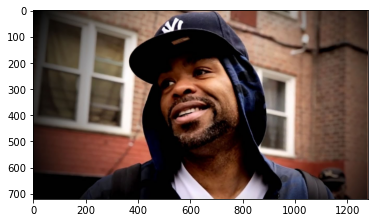

In [100]:
img=plt.imread(os.path.join(images_dir, test_images[0]))
plt.imshow(img)
plt.show()

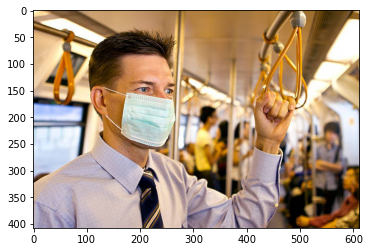

In [101]:
img=plt.imread(os.path.join(images_dir, train_images[1]))
plt.imshow(img)
plt.show()

In [102]:
options=['face_with_mask','face_no_mask']
train= train[train['classname'].isin(options)]
train.sort_values('name',axis=0,inplace=True)

/Users/brtonnies/anaconda3/envs/AI/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


/Users/brtonnies/anaconda3/envs/AI/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


[[112, 113, 262, 307]]


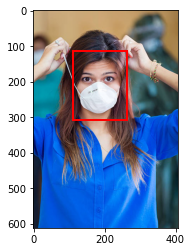

In [103]:
bbox=[]
for i in range(len(train)):
    arr=[]
    for j in train.iloc[i][["x1",'x2','y1','y2']]:
        arr.append(j)
    bbox.append(arr)
train["bbox"]=bbox  

def get_boxes(id):
    boxes=[]
    for i in train[train["name"]==str(id)]["bbox"]:
        boxes.append(i)
    return boxes

print(get_boxes(train_images[3]))
image=train_images[3]

img=plt.imread(os.path.join(images_dir,image))

fig,ax = plt.subplots(1)
ax.imshow(img)
boxes=get_boxes(image)
for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

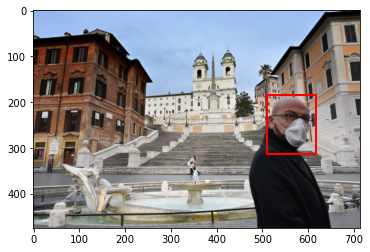

In [104]:
image=train_images[5]

img=plt.imread(os.path.join(images_dir,image))

fig,ax = plt.subplots(1)
ax.imshow(img)
boxes=get_boxes(image)
for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

<BarContainer object of 2 artists>

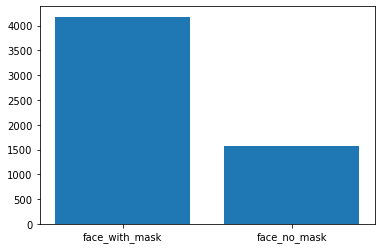

In [105]:
plt.bar(['face_with_mask','face_no_mask'],train.classname.value_counts())

# Creating training data

In [86]:
img_size=50
data=[]
path='../data/images/'
def create_data():
for i in range(len(train)):
    name, x, y, w, h, classname = list(train.iloc[i])
#     print(name, x, y, w, h, classname)
    url = os.path.join(KAGGLE_IMAGES_DIR, "{}?raw=true".format(name))
    resp = urllib.request.urlopen(url)
    img_arr = np.asarray(bytearray(resp.read()), dtype="uint8")
    og_img = cv2.imdecode(img_arr, cv2.IMREAD_GRAYSCALE)
#     image = utils.get_image(name, options={'lib': 'cv2'})
#     og_img = cv2.imread(os.path.join(IMAGES_DIR, name), cv2.IMREAD_GRAYSCALE)
    cropped = og_img[y:h, x:w]
    if len(cropped) > 0:
        new_img = cv2.resize(cropped, (50, 50)) # resize img to 50x50
        data.append([new_img, classname])


            
create_data()

len(train)

Creating Training Data -- 0.0%


5749

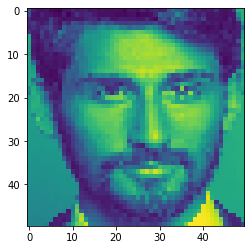

In [50]:
data[0][0]
plt.imshow(data[0][0])

In [51]:
len(data)

5749

In [107]:
x=[]
y=[]
for features, labels in data:
    x.append(features)
    y.append(labels)

# print(y)
lbl=LabelEncoder()
y=lbl.fit_transform(y)
y.shape

(5749,)

In [106]:
x=np.array(x).reshape(-1,50,50,1)
x=tf.keras.utils.normalize(x,axis=1)
from keras.utils import to_categorical
y = to_categorical(y)
y

array([[[0., 1.],
        [1., 0.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       ...,

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]]], dtype=float32)

# Model Fitting

In [89]:
from keras.layers import LSTM
model=Sequential()
model.add(Conv2D(100,(3,3), input_shape=x.shape[1:], activation='relu', strides=2))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))


In [55]:
# if no previously compiled model, then compile a new one

# does a previously compiled model exist?
if os.path.exists("../models/example_model"):
    model = keras.models.load_model("../models/example_model")
else:
    #  WARNING: THIS TAKES TIME -- USE THE COMPILED MODEL IF POSSIBLE
    opt = keras.optimizers.Adam(learning_rate=1e-3, epsilon=1e-5)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x, y, epochs=30, batch_size=5)
    model.save("../models/example_model")

In [56]:
def get_face_bounds(img):
    detector = MTCNN()
    image = plt.imread(os.path.join(images_dir, img))
    faces = detector.detect_faces(image)
    print(faces)
    bounds = []
    for (x, y, w, h) in [face['box'] for  face in faces]:
        bounding_box = cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 5)
        plt.imshow(bounding_box)
        bounds.append(bounding_box)

    return bounds

[{'box': [441, 108, 341, 416], 'confidence': 0.9999905824661255, 'keypoints': {'left_eye': (502, 270), 'right_eye': (642, 228), 'nose': (559, 296), 'mouth_left': (534, 412), 'mouth_right': (670, 373)}}]


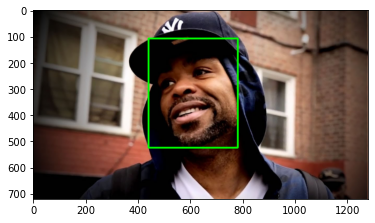

In [57]:
image = test_images[0]
bounding_boxes =  get_face_bounds(image)

[{'box': [66, 136, 31, 40], 'confidence': 0.9999638795852661, 'keypoints': {'left_eye': (86, 151), 'right_eye': (96, 152), 'nose': (95, 161), 'mouth_left': (84, 168), 'mouth_right': (93, 169)}}, {'box': [114, 135, 27, 32], 'confidence': 0.9999489784240723, 'keypoints': {'left_eye': (131, 146), 'right_eye': (140, 146), 'nose': (140, 154), 'mouth_left': (131, 160), 'mouth_right': (139, 160)}}, {'box': [479, 67, 55, 67], 'confidence': 0.9989905953407288, 'keypoints': {'left_eye': (489, 95), 'right_eye': (512, 94), 'nose': (496, 107), 'mouth_left': (489, 121), 'mouth_right': (512, 120)}}, {'box': [197, 130, 23, 31], 'confidence': 0.9981657862663269, 'keypoints': {'left_eye': (212, 144), 'right_eye': (219, 145), 'nose': (217, 153), 'mouth_left': (207, 156), 'mouth_right': (212, 157)}}, {'box': [447, 119, 12, 19], 'confidence': 0.9964094758033752, 'keypoints': {'left_eye': (449, 126), 'right_eye': (453, 127), 'nose': (447, 130), 'mouth_left': (448, 135), 'mouth_right': (451, 135)}}, {'box': 

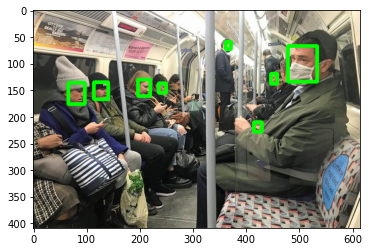

In [58]:
image = test_images[60]
bounding_boxes += get_face_bounds(image)

[{'box': [630, 176, 212, 266], 'confidence': 0.999250590801239, 'keypoints': {'left_eye': (682, 297), 'right_eye': (779, 297), 'nose': (718, 353), 'mouth_left': (681, 392), 'mouth_right': (754, 389)}}]


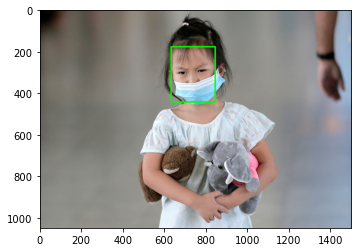

In [59]:
image = test_images[3]
bounding_boxes += get_face_bounds(image)

In [60]:
detector=MTCNN()
test_df=[]
for image in test_images:
    img=plt.imread(os.path.join(images_dir, image))
    faces=detector.detect_faces(img)
    
    test=[]
    for face in faces:
        bounding_box=face['box']
        test.append([image,bounding_box])
    test_df.append(test)
    
test=[]
for i in test_df:
    if len(i)>0:
        if len(i)==1:
            test.append(i[0])
        else:
            for j in i:
                test.append(j)

In [61]:
sub = []
rest_image = []
for i in test:
    sub.append(i[0])
for image in test_images:
    if image not in sub:
        rest_image.append(image) 


detector=MTCNN()
test_df_ = []
for image in rest_image:
    img = cv2.imread(os.path.join(images_dir,image))
    faces = detector.detect_faces(img)
    test_ = []
    for face in faces:
        bounding_box = face['box']
        test_.append([image, bounding_box])
    test_df_.append(test_) 
for i in test_df_:
    if len(i) > 0:
        if len(i) == 1:
            test.append(i[0])
        else:
            for j in i:
                test.append(j)      

In [62]:
sub = []
rest_image = []
for i in test:
    sub.append(i[0])
for image in test_images:
    if image not in sub:
        rest_image.append(image) 


detector=MTCNN()
test_df_ = []
for image in rest_image:
    img = cv2.imread(os.path.join(images_dir,image))
    faces = detector.detect_faces(img)
    test_ = []
    for face in faces:
        bounding_box = face['box']
        test_.append([image, bounding_box])
    test_df_.append(test_) 
for i in test_df_:
    if len(i) > 0:
        if len(i) == 1:
            test.append(i[0])
        else:
            for j in i:
                test.append(j)      

In [63]:
sub = []
rest_image = []
for i in test:
    sub.append(i[0])
for image in test_images:
    if image not in sub:
        rest_image.append(image) 


detector=MTCNN()
test_df_ = []
for image in rest_image:
    img = cv2.imread(os.path.join(images_dir,image))
    faces = detector.detect_faces(img)
    test_ = []
    for face in faces:
        bounding_box = face['box']
        test_.append([image, bounding_box])
    test_df_.append(test_) 
for i in test_df_:
    if len(i) > 0:
        if len(i) == 1:
            test.append(i[0])
        else:
            for j in i:
                test.append(j)      

In [64]:
sub = []
rest_image = []
for i in test:
    sub.append(i[0])
for image in test_images:
    if image not in sub:
        rest_image.append(image) 


detector=MTCNN()
test_df_ = []
for image in rest_image:
    img = cv2.imread(os.path.join(images_dir,image))
    faces = detector.detect_faces(img)
    test_ = []
    for face in faces:
        bounding_box = face['box']
        test_.append([image, bounding_box])
    test_df_.append(test_) 
for i in test_df_:
    if len(i) > 0:
        if len(i) == 1:
            test.append(i[0])
        else:
            for j in i:
                test.append(j)      

In [65]:
negative = []
for i in test:
    for j in i[1]:
        if j < 0:
            negative.append(i)
    

In [66]:
test_data=[]
def create_test_data():
            for j in test:
                if j not in negative:
                    img = cv2.imread(os.path.join(images_dir, j[0]), cv2.IMREAD_GRAYSCALE)
                    img = img[j[1][1]:j[1][1]+j[1][3],j[1][0]:j[1][0]+j[1][2]]
                    new_img = cv2.resize(img,(50,50))
                    new_img = new_img.reshape(-1,50,50,1)
                    predict = model.predict(new_img)
                    test_data.append([j, predict])

create_test_data()      

In [67]:
image = []
classname = []
for i, j in test_data:
    classname.append(np.argmax(j))
    image.append(i)
df=pd.DataFrame(columns=['image', 'classname'])
df['image'] = image
df['classname'] = classname
df['classname'] = lbl.inverse_transform(df['classname'])
image = []
x1 = []
x2 = []
y1 = []
y2 = []
for i in df['image']:
    image.append(i[0])
    x1.append(i[1][0])
    x2.append(i[1][1])
    y1.append(i[1][2])
    y2.append(i[1][3])
df['name'] = image
df['x1'] = x1
df['x2'] = x2
df['y1'] = y1
df['y2'] = y2    
df.drop(['image'],axis=1,inplace=True)

In [68]:
df.sort_values('name', axis=0, inplace=True, ascending=False)
df.to_csv('submission_1.csv')
df

,classname,name,x1,x2,y1,y2
3112,face_no_mask,1800.jpg,956,460,246,326
3111,face_with_mask,1799.jpg,757,296,75,86
3110,face_with_mask,1797.jpg,738,235,483,638
3109,face_with_mask,1796.jpg,469,223,186,229
3108,face_with_mask,1796.jpg,728,177,84,107
...,...,...,...,...,...,...
3,face_with_mask,0006.jpg,441,668,57,70
2,face_with_mask,0004.jpg,630,176,212,266
1,face_with_mask,0003.jpg,1292,218,865,1088
3113,face_with_mask,0002.png,349,102,212,268


In [69]:
len(df)

3183